Econ 430 Group member:
Kewei He, Kevin Zhao, Minghao Gu, Zirui Liu

I. Motivation for the projects: 

The purpose of this report is to present and analyze the results of a regression analysis conducted on the "nbasal" dataset from Wooldridge. The focus of the analysis is to understand the factors influencing wages and provide insights into the relationships between various variables.

II. Data Description:

The "nbasal" dataset is a comprehensive collection of variables related to NBA players' wages and other characteristics. The dataset includes information on age, experience, average minutes and various other factors that may impact wages.For better analysis, 
we selected 8 variables which we think is crucial in the reseach.

Variables Included in the Analysis:
1. wage: annual salary, thousands $
2. exper: years as professional player
3. games: average games per year
4. avgmin: minutes per game
5. avg_points: average points per ten minutes
6. avg_rebounds: average rebounds per ten minutes
7. avg_assists: average asssists per ten minutes
8. postion: the position of the player（guard,forward or center)

III.Results and Interpretation:

1.Descriptive Analysis:

From histogram and Cullen & Frey Graph, we find that the avgmin varaible subjects to the uniform distribution,
the avg_points variable subjects to the normal distribution and other variables subjects to beta distribution.There is no non-linearities within the variables and we tried to use Box-Cox transform to make our data better.We found that there are too many outliers through residuals plot,which we should deal with later in our regression.

2.Variable Selection:

Using the Boruta Algorithm, we find that the top 2 predictors are avgmin and exper.
Using Mallows Cp, we found that if there is only one predictor in one model, the top 2 predictor would be avgmin and avg_points.
If there are 2 predictors in one model, the predictors would be avgmin and exper.

3.Model Building: 

Based on Boruta Algorithm,Mallows Cp and 5-Fold CV MSE Scores, we found that avgmin would be the best predictor.The powerTransform test shows that no transformation is needed in this regression. After building a regression model, we found that the result cannot pass the Jarque-Bera test and Breush-Pagan test,which means the residuals didn't subject to normal distribution and there exists Heteroskedasticity.We tried to remove the outliers based on cook distance, and the model works well. The model is expressed as follows:

  Wage = 66.6167 * avgmin - 107.9914
  
suggesting that for each additional average minutes per game, the wage is expected to increase by 66,616.7$, holding other variables constant.

IV.Conclusion:
In conclusion, the regression analysis on the "nbasal" dataset provides valuable insights into the determinants of wages, showing that the average minutes per game is the best predictor for wages.To be more specific,for each additional average minutes per game, the wage is expected to increase by 66,616.7$. And other predictors also have a strong impact on nba players' wage. Overall, this study contributes to our understanding of wage differentials in NBA and provides a foundation for future research in the field of labor economics.

In [2]:
import wooldridge as woo
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
import seaborn as sns
import math
import pandas as pd
from ydata_profiling import ProfileReport
import rpy2
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from RegscorePy import mallow
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [3]:
#load original nbasal data from wooldridge
nbasal = woo.data('nbasal')
nbasal = pd.DataFrame(nbasal)
nbasal
# data = nbasal[['wage','exper','games','avgmin','points','rebounds','assists','position']]
# data

marr         wage  exper  age  coll  games  minutes  guard  forward  \
0       1  1002.500000      4   27     4     77     2867      1        0   
1       1  2030.000000      5   28     4     78     2789      1        0   
2       0   650.000000      1   25     4     74     1149      0        0   
3       0  2030.000000      5   28     4     47     1178      0        1   
4       0   755.000000      3   24     4     82     2096      1        0   
..    ...          ...    ...  ...   ...    ...      ...    ...      ...   
264     1  3210.000000      7   29     4     79     2638      1        0   
265     1   715.000122      5   31     4     75     1084      0        1   
266     1   600.000000     11   33     3     67     1197      1        0   
267     0  2500.000000      6   28     4     78     2113      0        0   
268     0  2000.000000     12   33     3     30      282      0        1   

     center  ...  assists  draft  allstar     avgmin     lwage  black  \
0         0  ...      4.5   19.0        0  37.233761  6.910252      1   
1         0  ...      8.8   28.0        0  35.756409  7.615791      1   
2         1  ...      0.2   19.0        0  15.527030  6.476973      1   
3         0  ...      1.5    1.0        0  25.063829  7.615791      1   
4         0  ...      2.6   24.0        0  25.560980  6.626718      1   
..      ...  ...      ...    ...      ...        ...       ...    ...   
264       0  ...      3.1   11.0        1  33.392410  8.074026      1   
265       0  ...      0.8   54.0        0  14.453330  6.572283      1   
266       0  ...      2.0    4.0        0  17.865669  6.396930      1   
267       1  ...      1.8    2.0        0  27.089741  7.824046      0   
268       0  ...      0.5    5.0        0   9.400000  7.600903      1   

     children  expersq  agesq  marrblck  
0           0       16    729         1  
1           1       25    784         1  
2           0        1    625         0  
3           0       25    784         0  
4           0        9    576         0  
..        ...      ...    ...       ...  
264         0       49    841         1  
265         1       25    961         1  
266         1      121   1089         1  
267         0       36    784         0  
268         0      144   1089         0  

[269 rows x 22 columns]

In [4]:
# clean the original data 
nbasal['position'] = 0
nbasal['avg_points'] = 0
nbasal['avg_rebounds'] = 0
nbasal['avg_assists'] = 0
for i in range(len(nbasal)):
    if nbasal['guard'][i] == 1 :
        nbasal['position'][i] = 'guard'
    elif nbasal['forward'][i] == 1:
        nbasal['position'][i] = 'forward'
    else:
        nbasal['position'][i] = 'center'
    nbasal['avg_points'][i] = round(nbasal['points'][i]*10/nbasal['avgmin'][i],1)
    nbasal['avg_rebounds'][i] = round(nbasal['rebounds'][i]*10/nbasal['avgmin'][i],1)
    nbasal['avg_assists'][i] = round(nbasal['assists'][i]*10/nbasal['avgmin'][i],1)

data = nbasal[['wage','exper','games','avgmin','avg_points','avg_rebounds','avg_assists','position']]
data

wage  exper  games     avgmin  avg_points  avg_rebounds  \
0    1002.500000      4     77  37.233761         4.2           1.0   
1    2030.000000      5     78  35.756409         3.7           0.7   
2     650.000000      1     74  15.527030         3.5           2.1   
3    2030.000000      5     47  25.063829         2.9           2.0   
4     755.000000      3     82  25.560980         4.2           1.7   
..           ...    ...    ...        ...         ...           ...   
264  3210.000000      7     79  33.392410         6.0           0.8   
265   715.000122      5     75  14.453330         3.3           1.7   
266   600.000000     11     67  17.865669         5.8           0.9   
267  2500.000000      6     78  27.089741         5.8           2.3   
268  2000.000000     12     30   9.400000         2.4           2.7   

     avg_assists position  
0            1.2    guard  
1            2.5    guard  
2            0.1   center  
3            0.6  forward  
4            1.0    guard  
..           ...      ...  
264          0.9    guard  
265          0.6  forward  
266          1.1    guard  
267          0.7   center  
268          0.5  forward  

[269 rows x 8 columns]

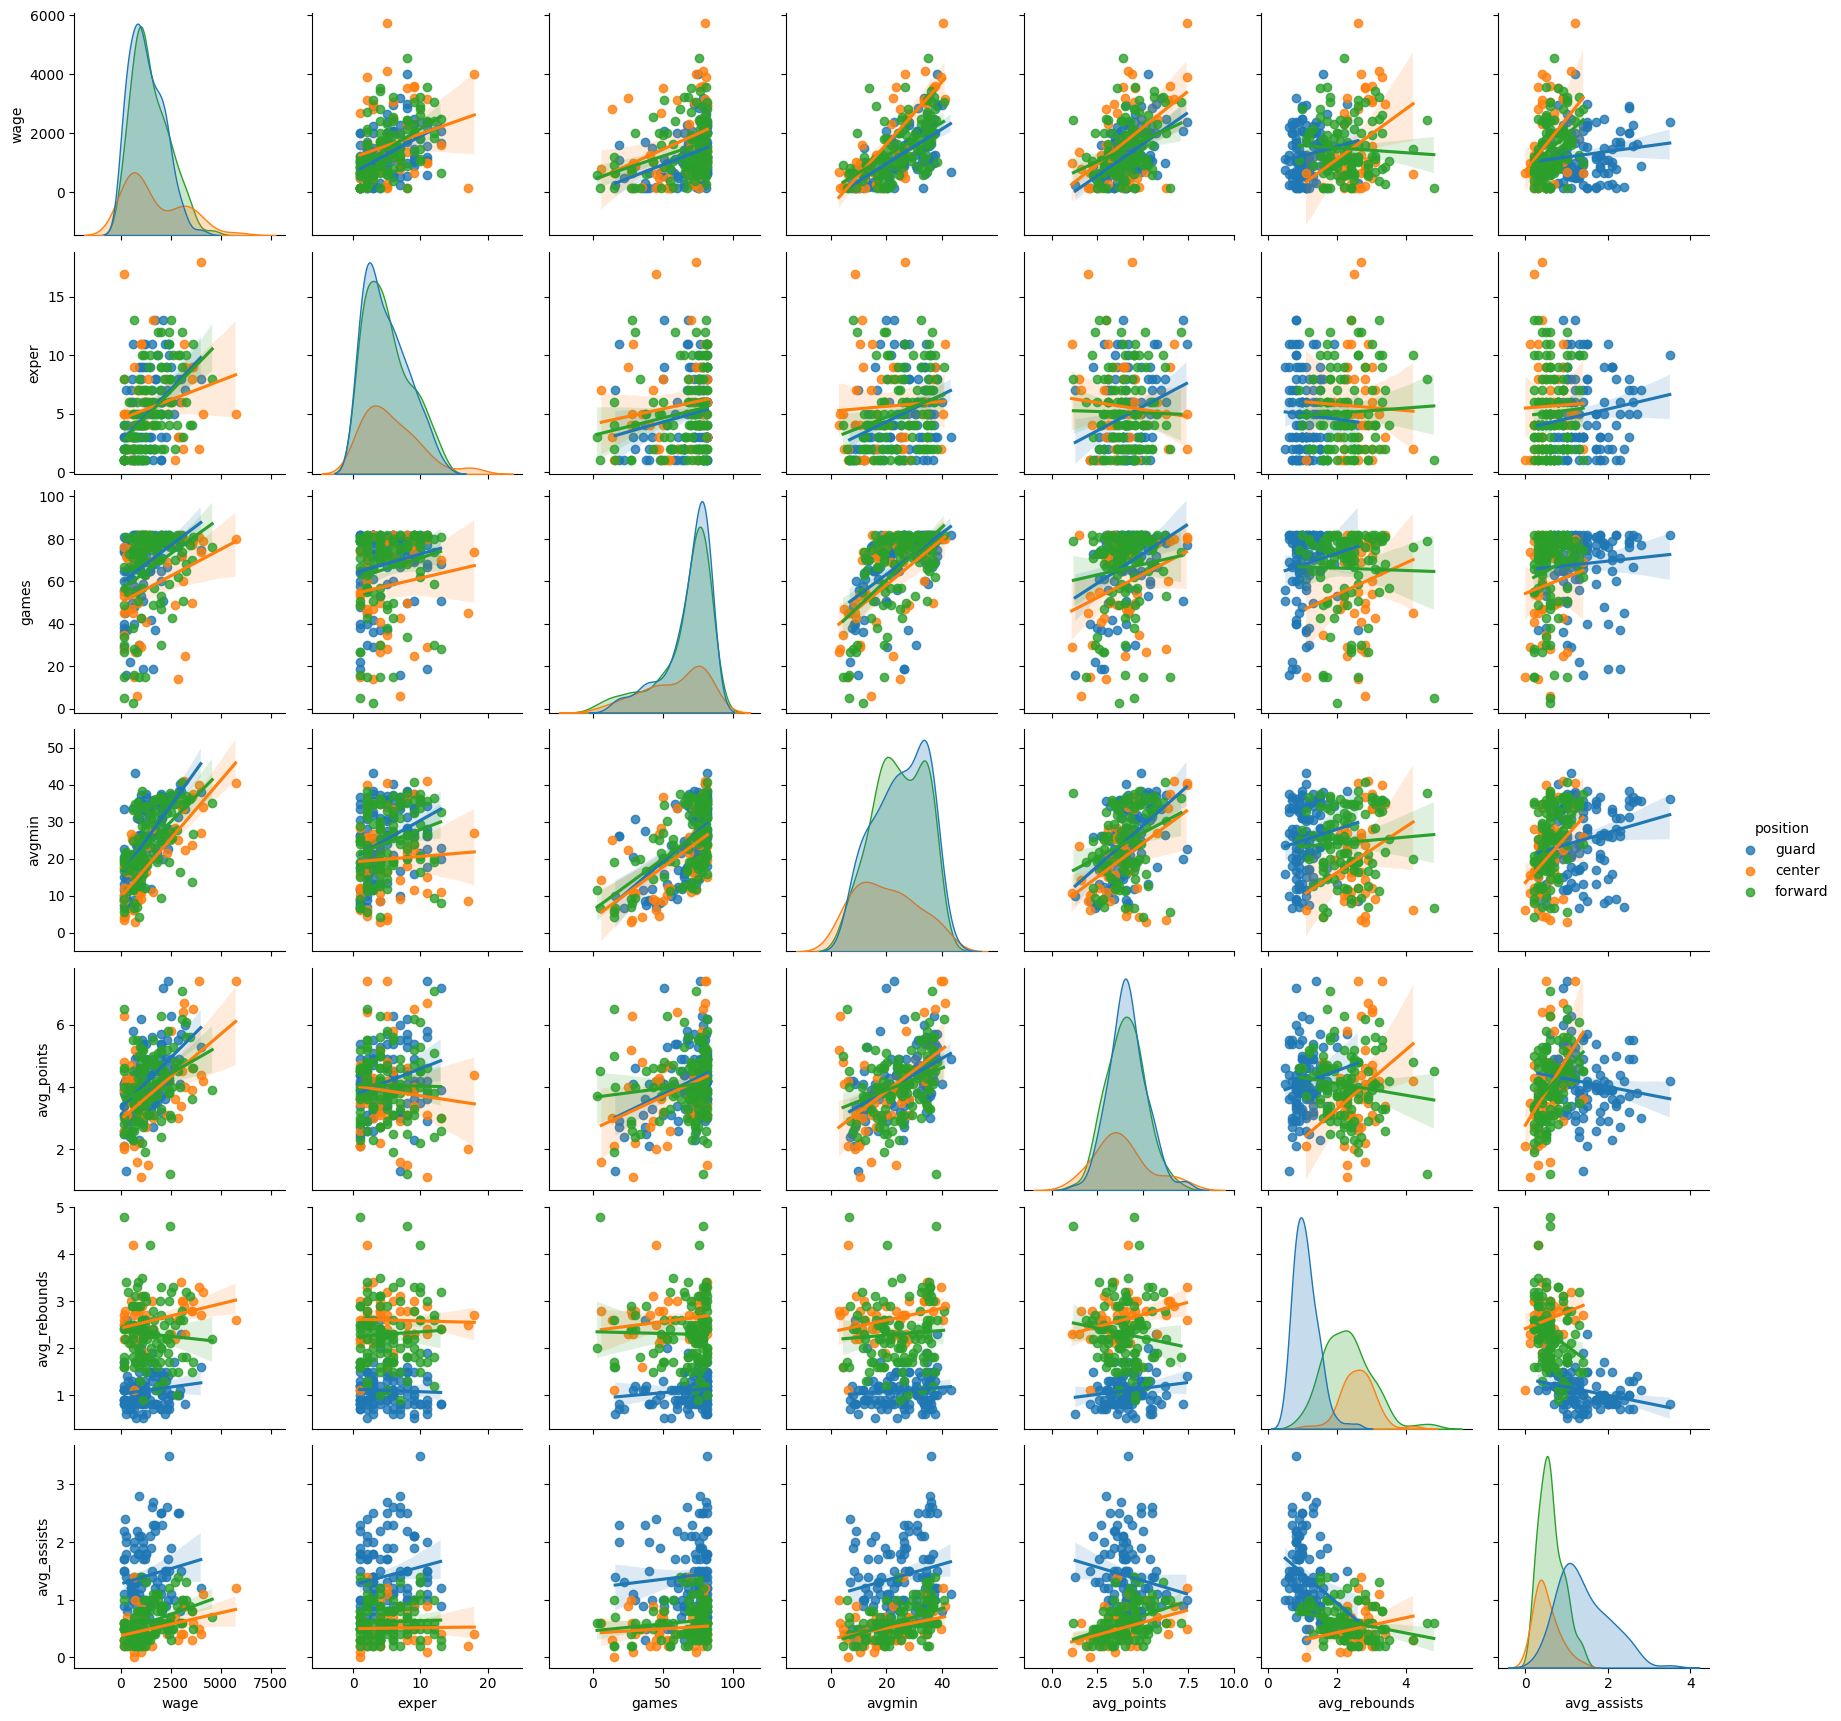

In [5]:
# 1.a providing a descriptive analysis of the variables
# pairplot
sns.pairplot(data,hue = 'position', kind = 'reg')

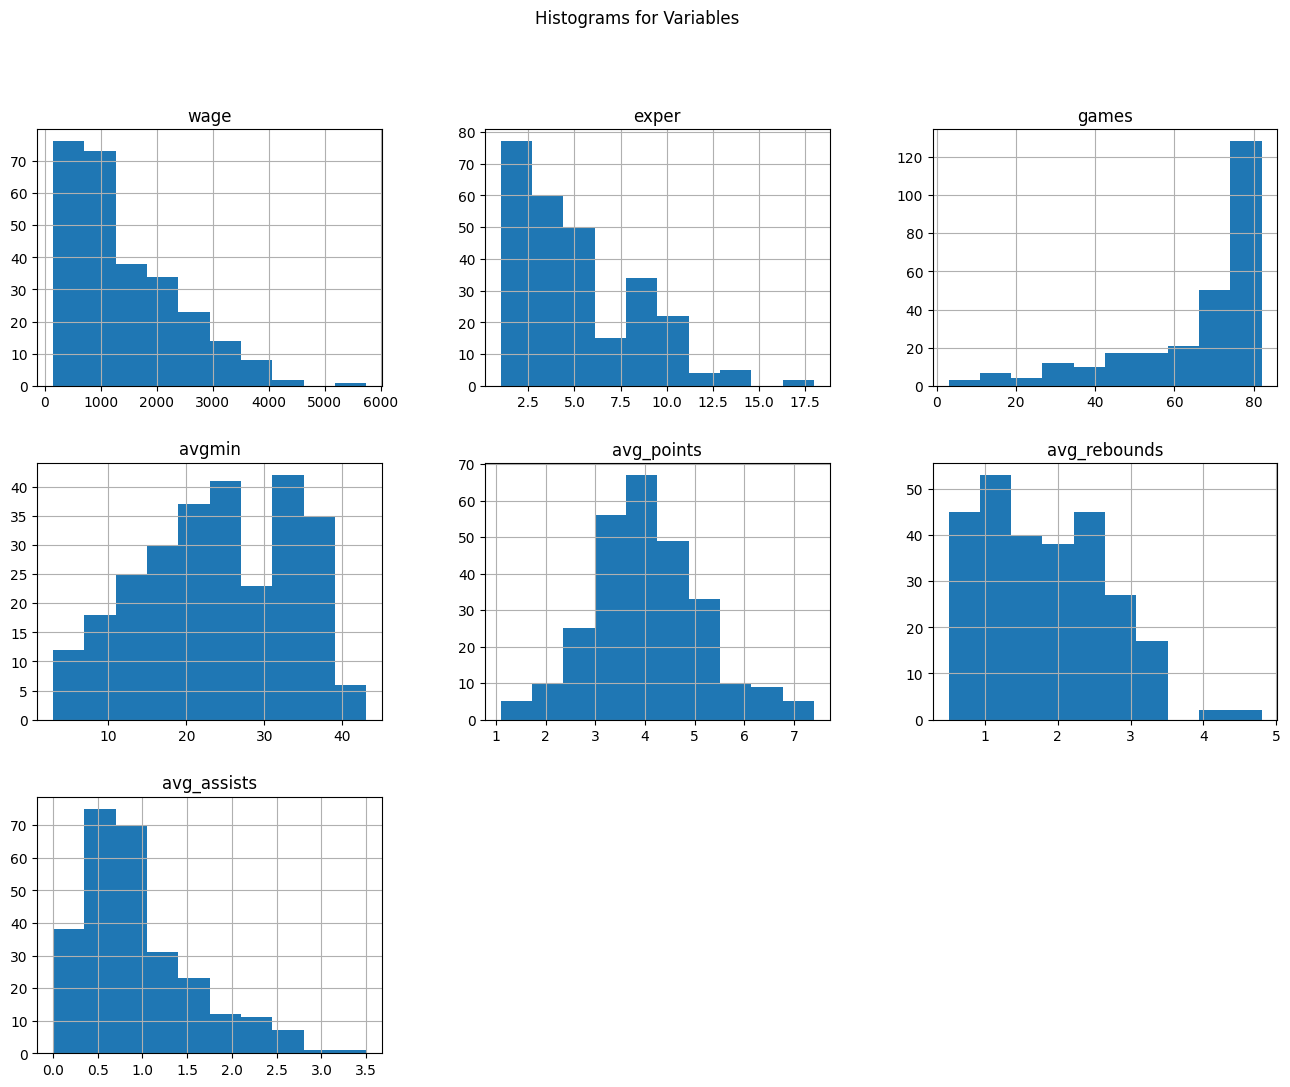

In [6]:
# histplot of variables
data.hist(figsize = (16,12))
plt.suptitle('Histograms for Variables')
plt.show()

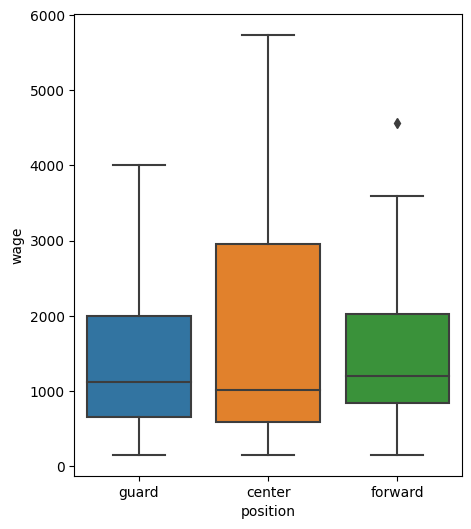

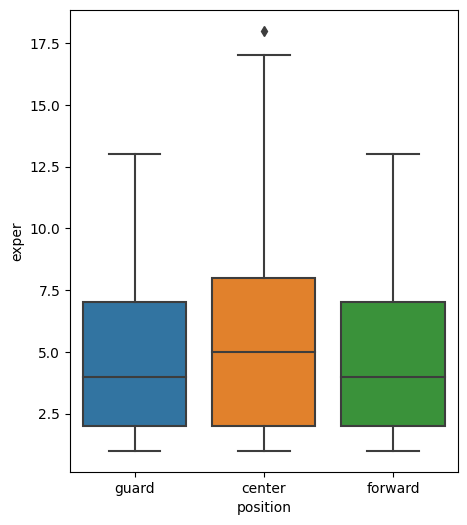

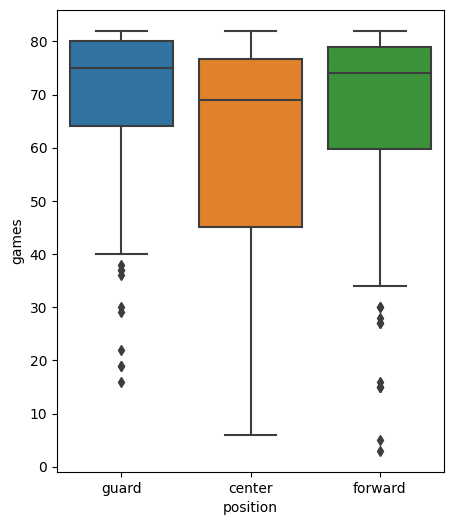

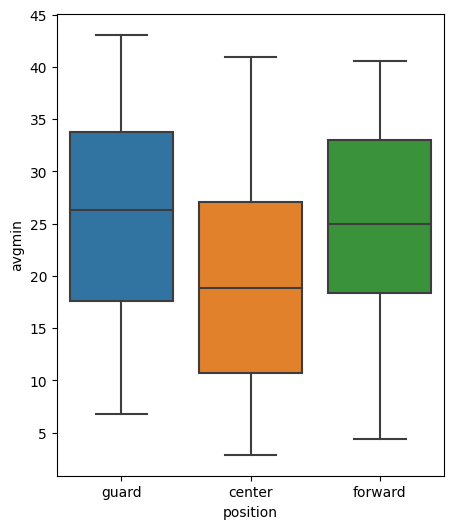

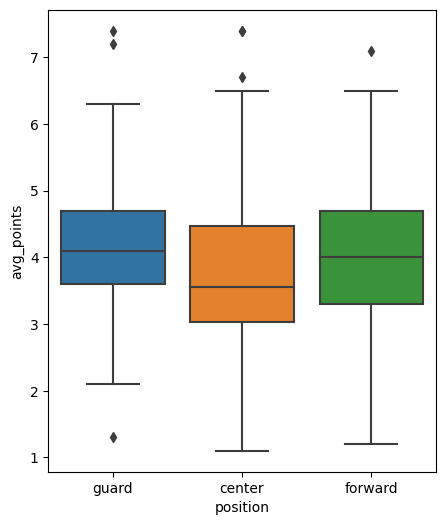

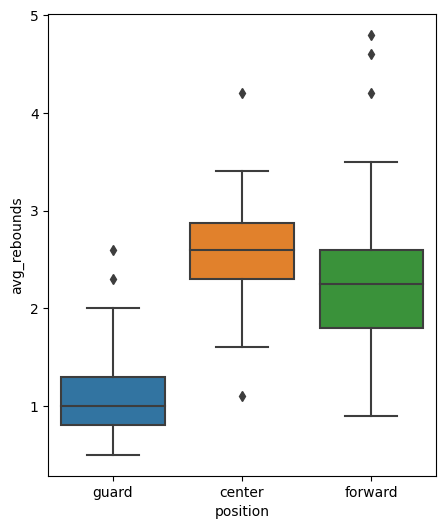

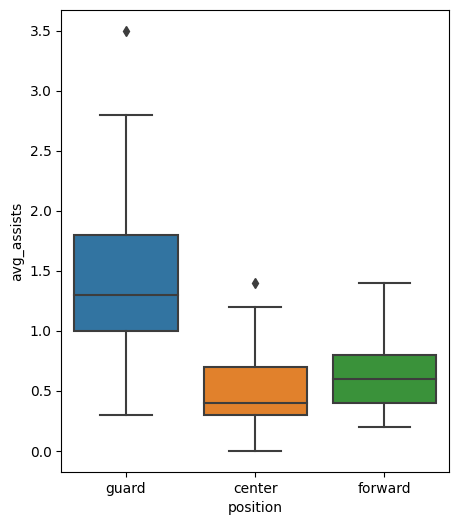

In [7]:
for column in data.columns[:-1]:
    plt.figure(figsize = (5, 6))
    sns.boxplot(x = "position", y = column, data = data)
    plt.ylabel(column)
    plt.show()

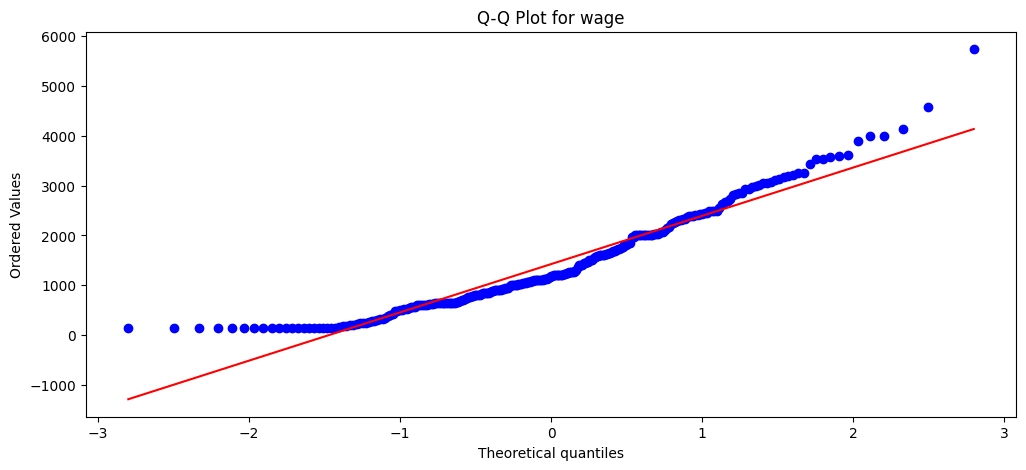

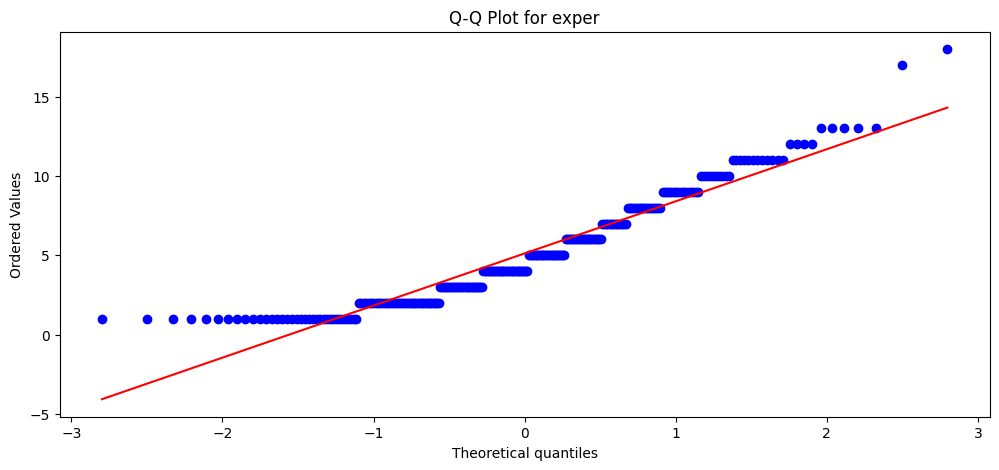

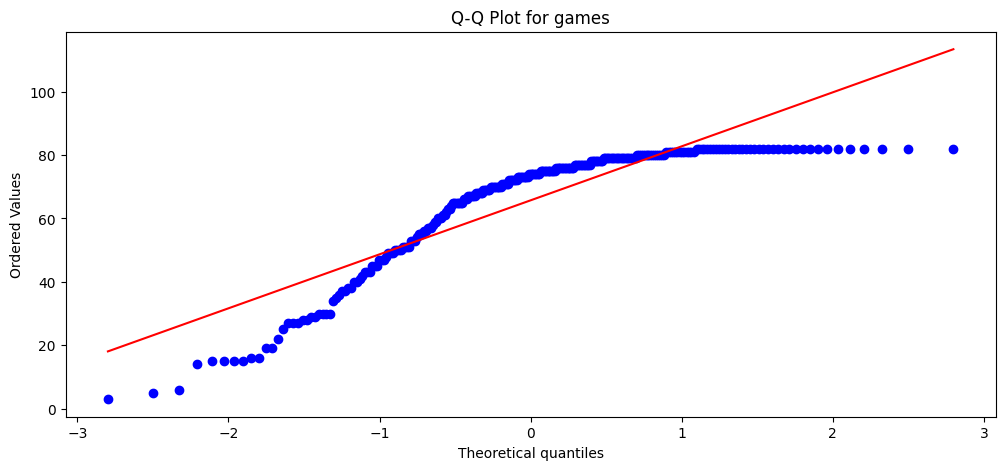

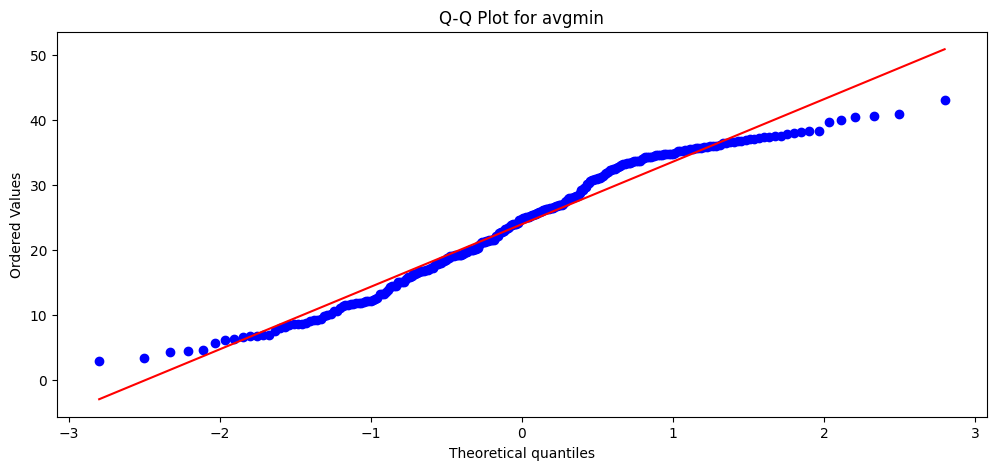

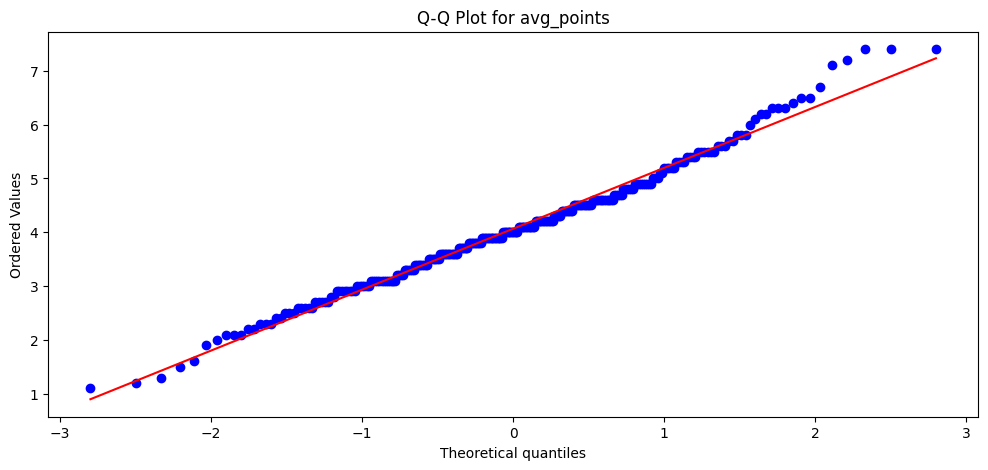

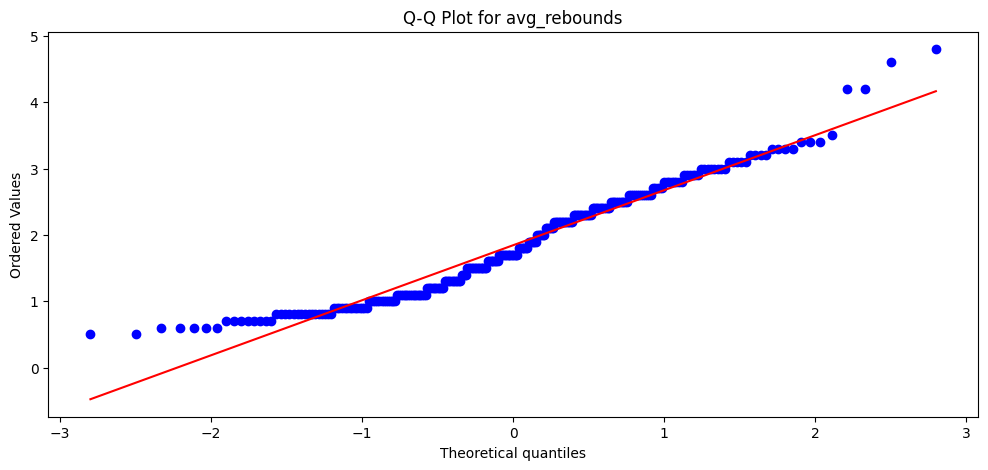

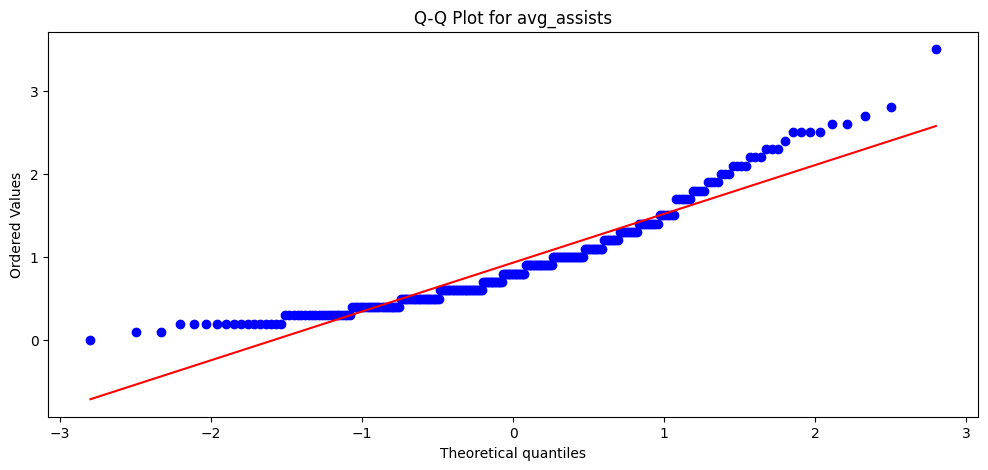

In [9]:
for column in data.columns[:-1]:
    plt.figure(figsize = (12, 5))
    stats.probplot(data[column],dist = 'norm',plot = plt)
    plt.title(f'Q-Q Plot for {column}')
    plt.show()
# The qqplot shows that wage doesn't fit a normal distribution

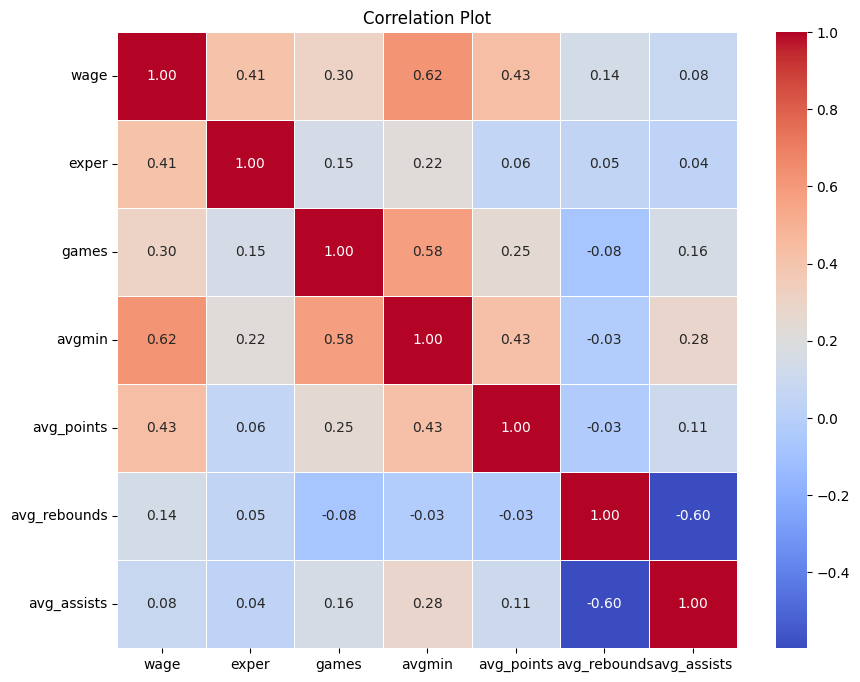

In [19]:
# correlation plot for data
# del data['position']
corr_matrix = data.iloc[:,0:7].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [5]:
# 1.b doing an exploratory analysis using Pandas Profiling
profile = ProfileReport(data, title="Profiling Report")
profile
# We find that their is a dulplicate row in our dataset


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [109]:
# remove the duplicate row
data = data.drop_duplicates()

In [1]:
# 1.c Estimate density distributions (Cullen & Frey) for all the variables
# use R function in python
from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

D:\Anaconda\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


summary statistics
------
min:  150   max:  5740 
median:  1186 
mean:  1423.828 
estimated sd:  999.7741 
estimated skewness:  0.9621844 
estimated kurtosis:  3.888279 


载入需要的程辑包：MASS
载入需要的程辑包：survival

载入程辑包：'wooldridge'

The following object is masked from 'package:MASS':

    cement



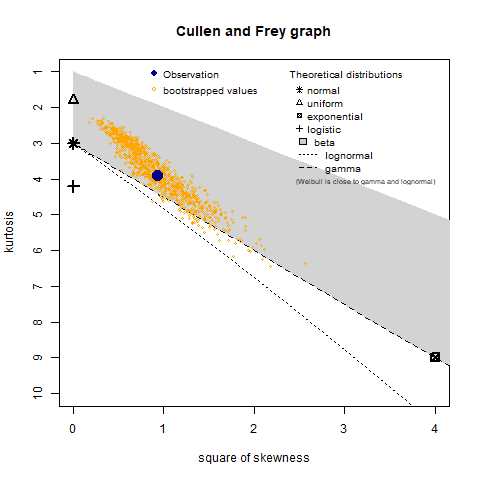

In [14]:
%%R 
#install.packages("fitdistrplus", dependencies=TRUE)
#install.packages("wooldridge", dependencies=TRUE)
library(fitdistrplus)
library(wooldridge)
descdist(nbasal$wage, boot = 1000)
# Cullen & Frey Graph of wage, it's likely a gamma or beta distribution

summary statistics
------
min:  1   max:  18 
median:  4 
mean:  5.118959 
estimated sd:  3.400062 
estimated skewness:  0.8205905 
estimated kurtosis:  3.268831 


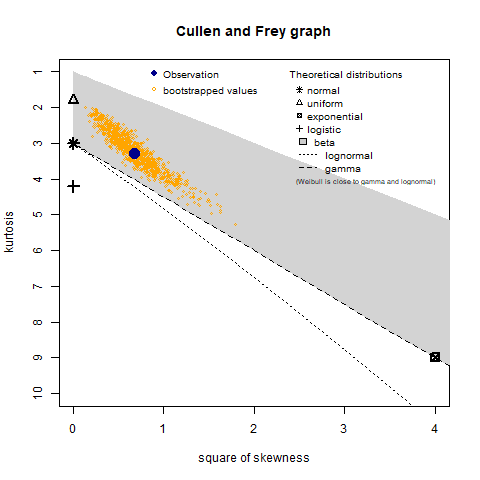

In [33]:
%%R 
# Cullen & Frey Graph of exper,it's likely a beta distribution
descdist(nbasal$exper, boot = 1000)

summary statistics
------
min:  3   max:  82 
median:  74 
mean:  65.72491 
estimated sd:  18.85111 
estimated skewness:  -1.422255 
estimated kurtosis:  4.173303 


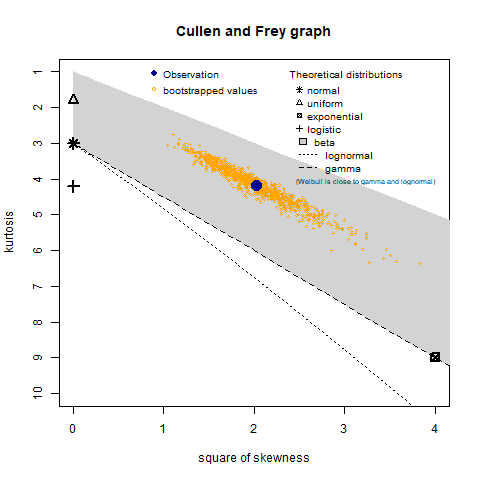

In [34]:
%%R 
# Cullen & Frey Graph of games,it's likely a beta distribution
descdist(nbasal$games, boot = 1000)


summary statistics
------
min:  2.888889   max:  43.08537 
median:  24.8169 
mean:  23.97925 
estimated sd:  9.731177 
estimated skewness:  -0.2020901 
estimated kurtosis:  1.986429 


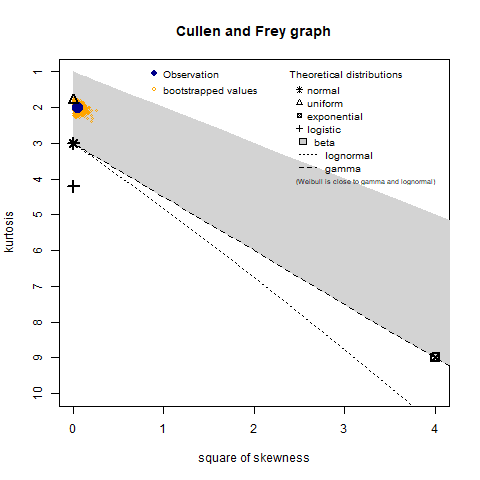

In [35]:
%%R 
# Cullen & Frey Graph of avgmin,it's likely a uniform distribution
descdist(nbasal$avgmin, boot = 1000)

summary statistics
------
min:  1.1   max:  7.4 
median:  4 
mean:  4.065056 
estimated sd:  1.130928 
estimated skewness:  0.3212045 
estimated kurtosis:  3.504285 


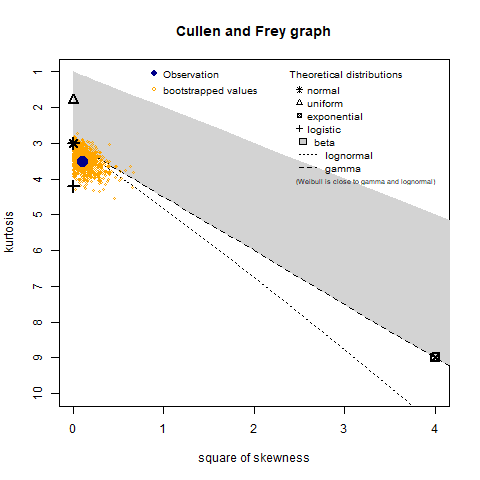

In [36]:
%%R
# Cullen & Frey Graph of avg_points,it's likely a normal distribution
nbasal$avg_points <- round(nbasal$points*10/nbasal$avgmin,1)
descdist(nbasal$avg_points, boot = 1000)

summary statistics
------
min:  0.5   max:  4.8 
median:  1.7 
mean:  1.844238 
estimated sd:  0.8440829 
estimated skewness:  0.5282166 
estimated kurtosis:  2.831699 


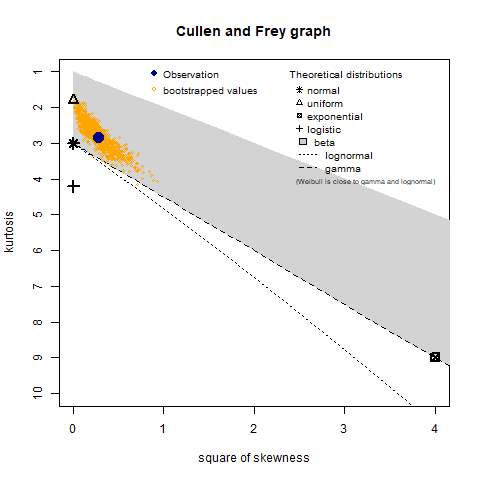

In [37]:
%%R
# Cullen & Frey Graph of avg_rebounds,it's likely a beta or uniform distribution
nbasal$avg_rebounds <- round(nbasal$rebounds*10/nbasal$avgmin,1)
descdist(nbasal$avg_rebounds, boot = 1000)

summary statistics
------
min:  0   max:  3.5 
median:  0.8 
mean:  0.9327138 
estimated sd:  0.6145382 
estimated skewness:  1.194881 
estimated kurtosis:  4.277549 


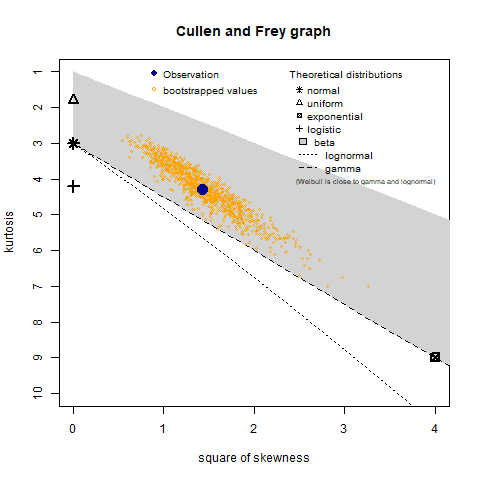

In [38]:
%%R
# Cullen & Frey Graph of avg_assists,it's likely a beta distribution
nbasal$avg_assists <- round(nbasal$assists*10/nbasal$avgmin,1)
descdist(nbasal$avg_assists, boot = 1000)

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)


sumsquare_error          aic          bic  kl_div  ks_statistic  \
nakagami         0.000004  1867.632536  1878.416670     inf      0.149246   
chi              0.000004  1939.770924  1950.555058     inf      0.169591   
exponpow         0.000004  1874.593508  1885.377642     inf      0.169366   
beta             0.000004  1871.110765  1885.489611     inf      0.136208   
gompertz         0.000004  1923.214982  1933.999116     inf      0.078067   

             ks_pvalue  
nakagami  1.075015e-05  
chi       3.115079e-07  
exponpow  3.247671e-07  
beta      8.168518e-05  
gompertz  7.139237e-02

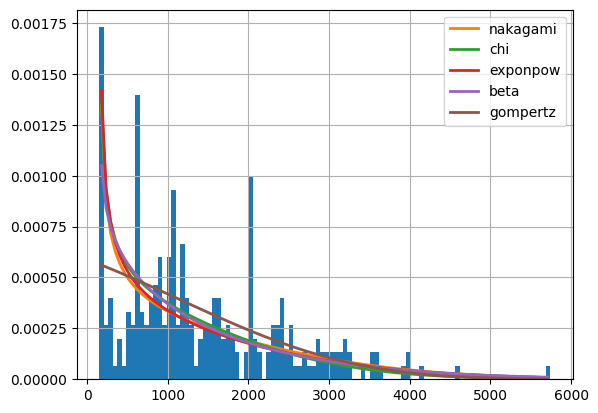

In [39]:
# use python Fitter to estimate distribution, here's the result for wage,it's likely a beta distribution based on AIC 
# Fit various distributions:
from fitter import Fitter
f = Fitter(data.wage)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

In [15]:
# 1.d
# Linearity: Harvey-Collier --> Ho: model is linear
from simple_colors import *
for col in data.iloc[:,1:7]:
    ols_mod = smf.ols(formula='wage ~ '+col, data=data)
    ols_fit = ols_mod.fit()
    name = ["t-stat", "p-value"]
    test = sms.linear_harvey_collier(ols_fit)
    print(blue(col+ " Linearity Test Results:",['bold']))
    print(list(zip(name, test)))
    print("\n")
#There's no non-linearities within the variables,we would perform  Box-Cox scale power transformation to make them linear
#Including non-linear variables in linear regression would result in Biased Parameter Estimates

exper Linearity Test Results:
[('t-stat', -0.05242729011352986), ('p-value', 0.9582277281448446)]


games Linearity Test Results:
[('t-stat', 0.49848635295536153), ('p-value', 0.6185547704234972)]


avgmin Linearity Test Results:
[('t-stat', 1.111678847407167), ('p-value', 0.26728379457163937)]


avg_points Linearity Test Results:
[('t-stat', 0.5137230308063778), ('p-value', 0.6078737174315043)]


avg_rebounds Linearity Test Results:
[('t-stat', 0.06687174792292123), ('p-value', 0.9467342285473683)]


avg_assists Linearity Test Results:
[('t-stat', 0.3123196893065512), ('p-value', 0.7550431914470798)]




In [76]:
# if using Box-cox scale power transformation, the lambda would be:
bc_data = pd.DataFrame()
bc_lambda = {}
data['avg_assists'] = data['avg_assists']+0.001
for col in data.iloc[:,:-1]:
    bc_data[col] = stats.boxcox(data[col])[0]
    bc_lambda[col] = stats.boxcox(data[col])[1]
bc_lambda


{'wage': 0.37678529203009037,
 'exper': 0.273799530119561,
 'games': 2.6317156397509343,
 'avgmin': 1.0073022193161991,
 'avg_points': 0.7267746934037638,
 'avg_rebounds': 0.30388505304294633,
 'avg_assists': 0.31232555515236565}

In [77]:
#the transformed data would be
bc_data

wage     exper         games     avgmin  avg_points  avg_rebounds  \
0    33.210942  1.686092  35031.882348  36.960453    2.528527      0.000000   
1    44.132615  2.022420  36241.940500  35.443781    2.184917     -0.338025   
2    27.808812  0.000000  31553.109147  14.733536    2.043971      0.832234   
3    44.132615  2.022420   9554.981531  24.481639    1.607100      0.771556   
4    29.576995  1.281735  41340.040109  24.990659    2.528527      0.575805   
..         ...       ...           ...        ...         ...           ...   
264  52.949911  2.570047  37477.579141  33.017825    3.683945     -0.215746   
265  28.922660  2.022420  32687.675843  13.638400    1.900806      0.575805   
266  26.903801  3.389759  24292.033030  17.120734    3.560799     -0.103692   
267  47.951720  2.312889  36241.940500  26.556368    3.560799      0.947803   
268  43.870886  3.559542   2931.351203   8.493051    1.223787      1.159442   

     avg_assists  
0       0.190257  
1       1.062456  
2      -1.627528  
3      -0.467904  
4       0.002997  
..           ...  
264    -0.100424  
265    -0.467904  
266     0.099550  
267    -0.333698  
268    -0.618430  

[269 rows x 7 columns]


载入程辑包：'olsrr'

The following object is masked from 'package:wooldridge':

    cement

The following object is masked from 'package:MASS':

    cement

The following object is masked from 'package:datasets':

    rivers

In addition: Warning message:
程辑包'olsrr'是用R版本4.1.3 来建造的 


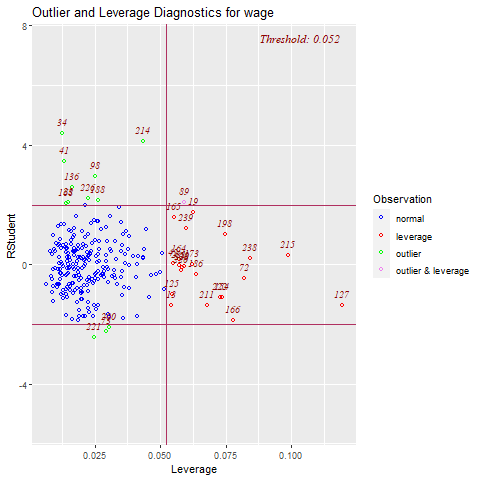

In [25]:
%%R
#1.e

#install.packages('olsrr')
library(olsrr)
mreg.mod <- lm(wage ~ exper + games + avgmin + avg_points + avg_rebounds + avg_assists, data=nbasal)
ols_plot_resid_lev(mreg.mod)
# With all the variables as predictor, there seems to be too many outliers and leverages, but fortunately no influence.
# We have to deal with the outliers later to make our model better

In [26]:
#1.f
# There's no NAs in our dataset
print(data.isnull().any())

wage            False
exper           False
games           False
avgmin          False
avg_points      False
avg_rebounds    False
avg_assists     False
position        False
dtype: bool


In [27]:
%%R
#2.a
#Boruta Algorithm
library(Boruta)
Bor.res <- Boruta(wage ~exper + games + avgmin + avg_points + avg_rebounds + avg_assists, data = nbasal, doTrace = 2)


 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
After 10 iterations, +0.3 secs: 
 confirmed 6 attributes: avg_assists, avg_points, avg_rebounds, avgmin, exper and 1 more;
 no more attributes left.

In addition: Warning message:
程辑包'Boruta'是用R版本4.1.3 来建造的 


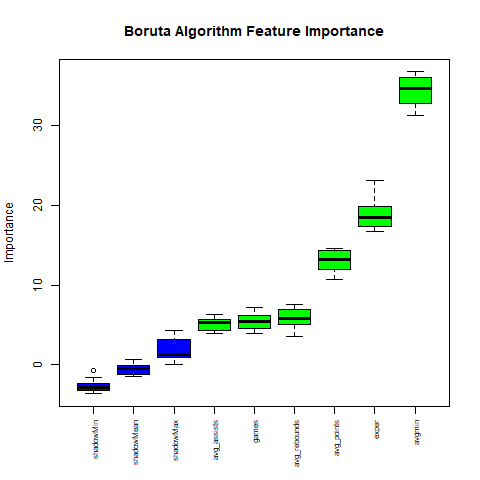

In [28]:
%%R
#plot(Bor.res,sort=TRUE)
plot(Bor.res, xlab = "", xaxt = "n", main="Boruta Algorithm Feature Importance")
lz<-lapply(1:ncol(Bor.res$ImpHistory),function(i)
Bor.res$ImpHistory[is.finite(Bor.res$ImpHistory[,i]),i])
names(lz) <- colnames(Bor.res$ImpHistory)
Labels <- sort(sapply(lz,median))
axis(side = 1,las=2,labels = names(Labels),
at = 1:ncol(Bor.res$ImpHistory), cex.axis = 0.7)
# the top 2 predictors would be avgmin and exper based on Boruta Algorithm

             Abbreviation
exper                   e
games                   g
avgmin                 av
avg_points          avg_p
avg_rebounds        avg_r
avg_assists         avg_s


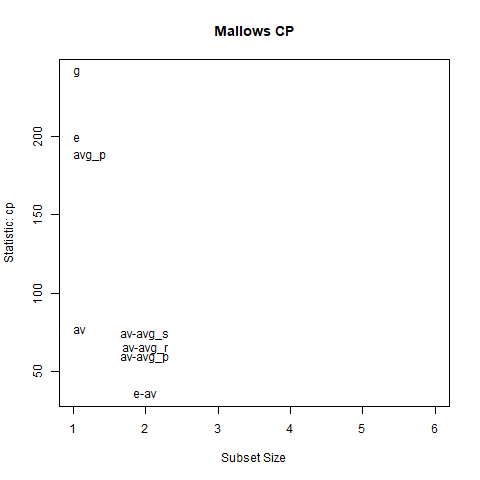

In [92]:
%%R
# 2.b Using Mallows Cp identify the top 2 predictors
# Example 36: Mallows Cp (Family Income)
library(car)
library(AER)
library(leaps)
ss=regsubsets(wage~exper + games + avgmin + avg_points + avg_rebounds + avg_assists,method=c("exhaustive"),nbest=4,data=nbasal,nvmax =2 )
subsets(ss,statistic="cp",legend=F,main="Mallows CP")
#If there is only one predictor in one model, the top 2 predictor would be avgmin and avg_points
#if there are 2 predictors in one model, the predictors would be avgmin and exper

In [30]:
#All the CP value in Mallows Cp methods
from RegscorePy import mallow
import itertools
model = smf.ols(formula='wage ~ exper + games + avgmin + avg_points + avg_rebounds + avg_assists', data=nbasal)
results = model.fit()
y = nbasal.wage
y_pred=results.fittedvalues
subdat = data.iloc[:,:-1].copy()
storage_cp = pd.DataFrame(columns = ["Variables", "CP"])
k = 7 # number of parameters in orginal model (includes y-intercept)

for L in range(1, len(subdat.columns[1:]) + 1):
    for subset in itertools.combinations(subdat.columns[1:], L):
        
        # join the strings in the data together
        formula1 = 'wage~'+'+'.join(subset)
        
        # get the cp
        results = smf.ols(formula=formula1, data = data).fit()
        y_sub = results.fittedvalues
        p = len(subset)+1 # number of parameters in the subset model (includes y-intercept)
        
        cp = mallow.mallow(y, y_pred,y_sub, k, p)
        
        # add to the dataframe
        storage_cp = storage_cp._append({'Variables': subset, 'CP': cp}, ignore_index = True)
storage_cp.sort_values(by = "CP")

Variables          CP
56   (exper, games, avgmin, avg_points, avg_rebounds)    5.000058
47          (exper, avgmin, avg_points, avg_rebounds)    5.514948
62  (exper, games, avgmin, avg_points, avg_rebound...    7.000000
60  (exper, avgmin, avg_points, avg_rebounds, avg_...    7.501546
57    (exper, games, avgmin, avg_points, avg_assists)   12.215127
..                                                ...         ...
1                                            (games,)  241.187706
14                               (games, avg_assists)  242.613446
20                        (avg_rebounds, avg_assists)  259.378319
4                                     (avg_rebounds,)  281.059627
5                                      (avg_assists,)  289.128909

[63 rows x 2 columns]

In [88]:
#3 
#In order to choose the optimal predictor, we run a Cross-Validation on each Linear regression model to find the smallest MSE
# The result shows that avgmin would be the best choice
for col in bc_data.iloc[:,1:]:
    x = bc_data[[col]]
    y = bc_data[['wage']]
    regr = LinearRegression()
    scores = cross_val_score(regr, x, y, cv=5, scoring='neg_mean_squared_error')
    print(col+' 5-Fold CV MSE Scores:', scores)


exper 5-Fold CV MSE Scores: [-135.0368381   -77.87988124  -93.86306409 -130.16677436  -80.78494163]
games 5-Fold CV MSE Scores: [-152.52887228 -116.67350838  -97.42986013 -113.99025754  -91.19592161]
avgmin 5-Fold CV MSE Scores: [-92.17467369 -79.58869097 -67.53426917 -70.49414918 -65.44059318]
avg_points 5-Fold CV MSE Scores: [-118.60704304  -97.95832458 -100.42609008 -116.5000074  -120.54225489]
avg_rebounds 5-Fold CV MSE Scores: [-156.80545147 -108.52420038 -111.63672705 -146.53179085 -124.00499958]
avg_assists 5-Fold CV MSE Scores: [-163.6280622  -110.11312789 -113.51569357 -140.81939237 -114.93155942]


In [48]:
%%R
# The powerTransform test shows that no transformation is needed
# The wage could be Box-Cox transformed based on the test before, but it would be difficult to interpret the model if we do so
summary(b <- powerTransform(avgmin ~ wage, nbasal))

bcPower Transformation to Normality 
   Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
Y1    1.0948           1       0.8544       1.3352

Likelihood ratio test that transformation parameter is equal to 0
 (log transformation)
                           LRT df       pval
LR test, lambda = (0) 99.99136  1 < 2.22e-16

Likelihood ratio test that no transformation is needed
                            LRT df    pval
LR test, lambda = (1) 0.6093908  1 0.43502


In [94]:
# try on the original regression model
ols_mod = smf.ols(formula='wage ~ avgmin', data=data)
ols_fit = ols_mod.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     168.3
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           3.59e-30
Time:                        19:05:31   Log-Likelihood:                -2173.6
No. Observations:                 269   AIC:                             4351.
Df Residuals:                     267   BIC:                             4358.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -107.9914    127.402     -0.848      0.3

In [95]:
#Evaluate the model
import statsmodels.stats.api as sms
from simple_colors import *
# Linearity: Harvey-Collier --> Ho: model is linear
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit)
print(blue("Linearity Test Results:",['bold']))
print(list(zip(name, test)))
print("\n")
# The model passed the linearity test

# Normaility of the Residuals: Jarque-Bera --> Residuals ~ N(0,1)
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(ols_fit.resid)
print(blue("JB Results:",['bold']))
print(list(zip(name, test)))
print("\n")
# The model cannot pass the Jarque-Bera test

# Heteroskedasticity: Breush-Pagan --> Ho: var = constant
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(ols_fit.resid, ols_fit.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))
# The model cannot pass the Breush-Pagan test


Linearity Test Results:
[('t-stat', 1.111678847407167), ('p-value', 0.26728379457163937)]


JB Results:
[('Jarque-Bera', 60.7879495953196), ('Chi^2 two-tail prob.', 6.310510043422998e-14), ('Skew', 0.8332524989025665), ('Kurtosis', 4.626721020714224)]


BP Results:
[('Lagrange multiplier statistic', 14.088371272762583), ('p-value', 0.00017441878457789942), ('f-value', 14.756467363254814), ('f p-value', 0.00015288280369075806)]


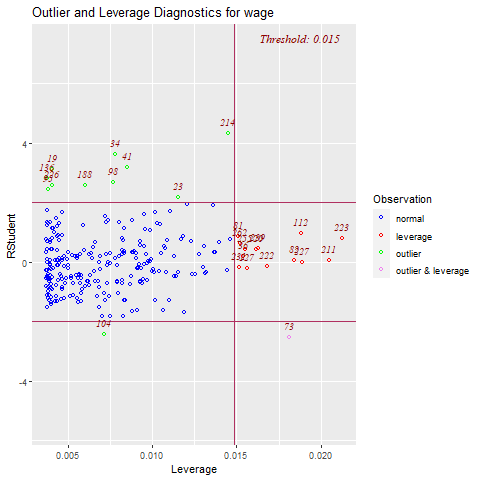

In [96]:
%%R
#install.packages('olsrr')
#Draw the residuals plot
library(olsrr)
mreg.mod <- lm(wage ~ avgmin, data=nbasal)
ols_plot_resid_lev(mreg.mod)

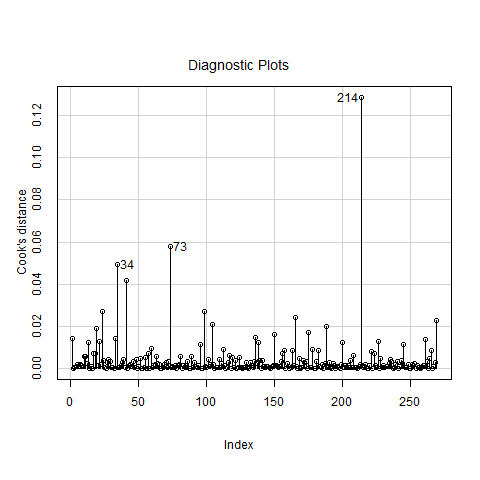

In [97]:
%%R
# Draw the cooks distance plot
library(car)
mreg.mod <- lm(wage ~ avgmin, data=nbasal)
influenceIndexPlot(mreg.mod, id=list(n=3),vars="Cook")

In [98]:
# remove the outliers base on cooks_distance
thresh = 1.2/len(ols_fit.fittedvalues)
cooks_distance = ols_fit.get_influence().cooks_distance[0]
data_new = data[cooks_distance < thresh]
data_new

wage  exper  games     avgmin  avg_points  avg_rebounds  \
1    2030.000000      5     78  35.756409         3.7           0.7   
2     650.000000      1     74  15.527030         3.5           2.1   
3    2030.000000      5     47  25.063829         2.9           2.0   
4     755.000000      3     82  25.560980         4.2           1.7   
5    2014.500000      9     82  24.036579         4.7           2.0   
..           ...    ...    ...        ...         ...           ...   
261   833.000000      1     27   6.888889         2.9           2.9   
262  2000.000000      7     79  34.316460         3.2           1.3   
265   715.000122      5     75  14.453330         3.3           1.7   
266   600.000000     11     67  17.865669         5.8           0.9   
267  2500.000000      6     78  27.089741         5.8           2.3   

     avg_assists position  
1          2.503    guard  
2          0.103   center  
3          0.603  forward  
4          1.003    guard  
5          0.603  forward  
..           ...      ...  
261        0.403  forward  
262        2.503    guard  
265        0.603  forward  
266        1.103    guard  
267        0.703   center  

[218 rows x 8 columns]

In [99]:
# Fit the linear regression after removing the outliers
ols_mod2 = smf.ols(formula='wage ~ avgmin', data=data_new)
ols_fit2 = ols_mod2.fit()
print(ols_fit2.summary())
# wage = 66.6167*avgmin - 266.56
# For every extra minute players play on the court, they earn an additional $66,617 wage

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     331.8
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.56e-45
Time:                        19:05:41   Log-Likelihood:                -1659.5
No. Observations:                 218   AIC:                             3323.
Df Residuals:                     216   BIC:                             3330.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -266.5605     88.604     -3.008      0.0

In [100]:
#Evaluate the model
import statsmodels.stats.api as sms
from simple_colors import *
# Linearity: Harvey-Collier --> Ho: model is linear
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit2)
print(blue("Linearity Test Results:",['bold']))
print(list(zip(name, test)))
print("\n")

# Normaility of the Residuals: Jarque-Bera --> Residuals ~ N(0,1)
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(ols_fit2.resid)
print(blue("JB Results:",['bold']))
print(list(zip(name, test)))
print("\n")

# Heteroskedasticity: Breush-Pagan --> Ho: var = constant
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(ols_fit2.resid, ols_fit2.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))
# The model passed all the three tests

Linearity Test Results:
[('t-stat', 1.9003916935373064), ('p-value', 0.05872587717012933)]


JB Results:
[('Jarque-Bera', 2.9608318268148452), ('Chi^2 two-tail prob.', 0.2275430305032846), ('Skew', 0.11283171461251368), ('Kurtosis', 2.475558245743678)]


BP Results:
[('Lagrange multiplier statistic', 2.886652685494931), ('p-value', 0.08931631771890729), ('f-value', 2.8985508702781453), ('f p-value', 0.09009780021536641)]


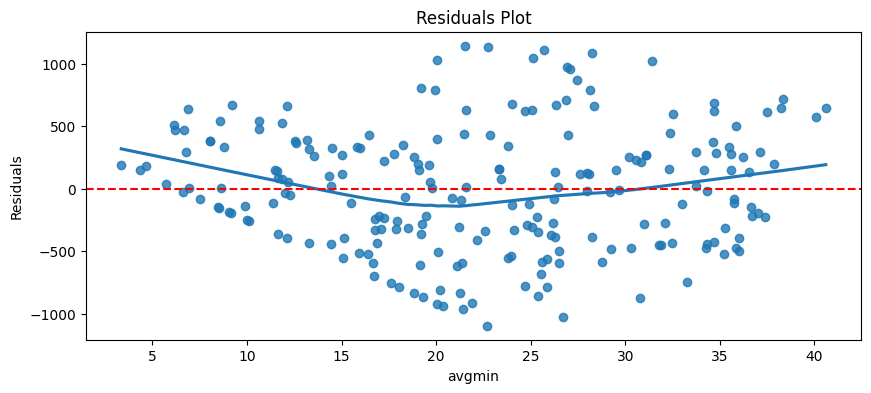

In [101]:
# Residuals Plot for the new model
plt.figure(figsize = (10, 4))
sns.regplot(x = data_new.avgmin, y = ols_fit2.resid,lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

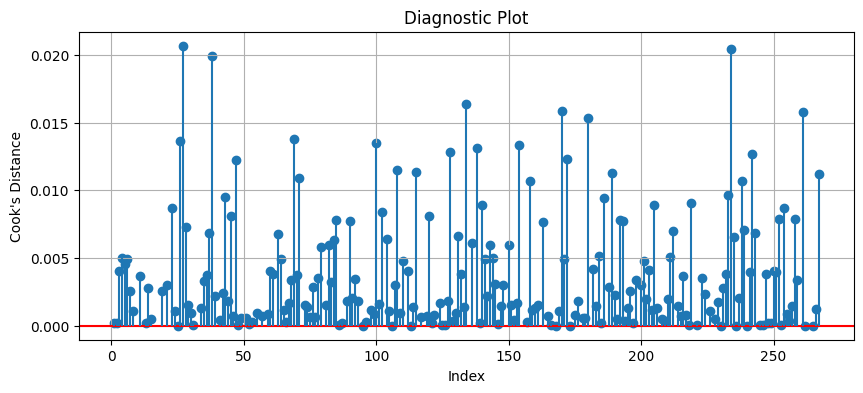

In [102]:
# Cook’s distance Plot for the new model
cooks_distance = ols_fit2.get_influence().cooks_distance[0]
plt.figure(figsize = (10, 4))
plt.scatter(data_new.index, cooks_distance)
plt.axhline(0, color = 'red')
plt.vlines(x = data_new.index, ymin = 0, ymax = cooks_distance)
plt.xlabel('Index')
plt.ylabel('Cook\'s Distance')
plt.title("Diagnostic Plot")
plt.grid()

In [103]:
#Evaluate the robustness of your coefficient estimates by bootstrapping your model
from scipy.stats import bootstrap
from sklearn.metrics import r2_score
# Note that you have to write your own functions that will work with
# scipy.stats bootstrap

# The first one takes in x and y, returns beta1
def reg_boot_b1(x,y):
    
    # bootstrap function gives us a 1d array, need 2d
    x = x.reshape((len(x),1))
    y = y.reshape((len(y),1))
    reg = LinearRegression().fit(x,y)
    
    # Pull out beta1 
    return reg.coef_[0][0]

# The first one takes in x and y, returns beta0
def reg_boot_r_squared(x,y):
    
    # bootstrap function gives us a 1d array, need 2d
    x = x.reshape((len(x),1))
    y = y.reshape((len(y),1))
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    r_squared = r2_score(y, y_pred)
    # Pull out r_squared
    return r_squared



In [104]:
#bootstrap for beta1
X = data_new.avgmin
Y = data_new.wage
res = bootstrap((X,Y), reg_boot_b1, confidence_level=0.95, vectorized = False, method = 'BCa',
                paired = True)

In [61]:
print(res.confidence_interval)

ConfidenceInterval(low=60.604700045735, high=72.47030162065765)


Text(0.5, 1.0, 'Bootstrapped beta1')

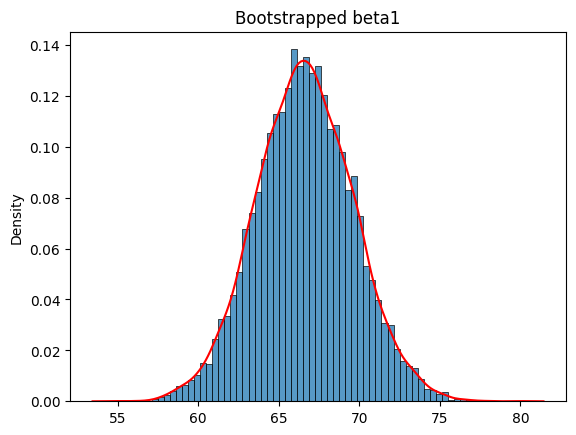

In [107]:
sns.histplot(res.bootstrap_distribution,stat = 'density')
sns.kdeplot(res.bootstrap_distribution,color = 'red')
plt.title('Bootstrapped beta1')
# The result is accordance with the LS

In [63]:
#bootstrap for r_squared
res2 = bootstrap((X,Y), reg_boot_r_squared, confidence_level=0.95, vectorized = False, method = 'BCa',
                paired = True)

Text(0.5, 1.0, 'Bootstrapped R square')

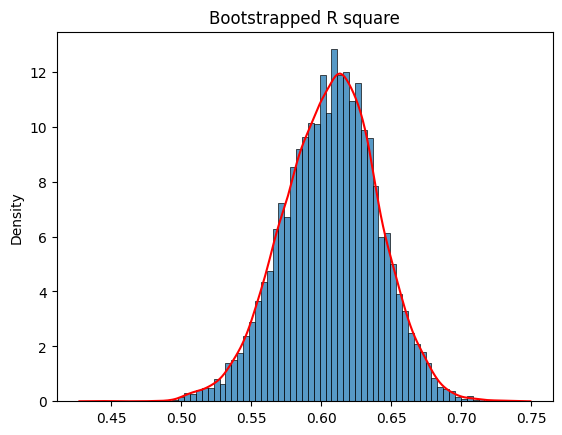

In [108]:
sns.histplot(res2.bootstrap_distribution,stat = 'density')
sns.kdeplot(res2.bootstrap_distribution,color = 'red')
plt.title('Bootstrapped R square')

In [105]:
#Use cross-validation to evaluate model’s performance
#Compared to the original model before removing the outliers
x = data[['avgmin']]
y = data[['wage']]
regr = LinearRegression()
scores = cross_val_score(regr, x, y, cv=5, scoring='neg_mean_squared_error')
print('Original Model 5-Fold CV MSE Scores:', scores)

x = data_new[['avgmin']]
y = data_new[['wage']]
regr = LinearRegression()
scores = cross_val_score(regr, x, y, cv=5, scoring='neg_mean_squared_error')
print('New Model 5-Fold CV MSE Scores:', scores)
# The results are much better

Original Model 5-Fold CV MSE Scores: [-853332.38663903 -589478.52956091 -496253.96500115 -693924.69569157
 -475713.95702321]
New Model 5-Fold CV MSE Scores: [-249385.32077263 -262174.51796304 -247309.56591498 -253550.36307814
 -212508.85913815]


In [5]:
%%R
install.packages('PoEdata')
library(PoEdata)

将程序包安装入'C:/Users/17206/Documents/R/win-library/4.1'
(因为'lib'没有被指定)
Error in library(PoEdata) : 不存在叫'PoEdata'这个名字的程辑包
In addition: Warning message:
package 'PoEdata' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages
Error in library(PoEdata) : 不存在叫'PoEdata'这个名字的程辑包


RInterpreterError: Failed to parse and evaluate line "install.packages('PoEdata')\nlibrary(PoEdata)\n".
R error message: "Error in library(PoEdata) : 不存在叫'PoEdata'这个名字的程辑包"
R stdout:
将程序包安装入'C:/Users/17206/Documents/R/win-library/4.1'
(因为'lib'没有被指定)
Error in library(PoEdata) : 不存在叫'PoEdata'这个名字的程辑包
In addition: Warning message:
package 'PoEdata' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages